In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 112
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 112
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        ###
        landmarks = landmarks / torch.tensor([np.array(image).shape[0]/224, np.array(image).shape[0]/224])
        ###
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        
        if(width > height) :
            left = left - width*0.25
            top = top + height*0.5 - width*0.5 - width*0.25
            width = width*1.5
            height = width
        else :
            top = top - height*0.25
            left = left + width*0.5 - height*0.5 - height*0.25
            height = height*1.5
            width = height

        image = TF.crop(image, top, left, height, width)
        
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        #landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        
        return image, landmarks

class Transforms_Flip():
    def __init__(self):
        pass

    def flip(self, image, landmarks):
        image = cv2.flip(np.array(image), 1)
        landmarks[:, 0] = image.shape[1] - landmarks[:, 0]
        return Image.fromarray(image), landmarks
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 112
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 112
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        ###
        landmarks = landmarks / torch.tensor([np.array(image).shape[0]/224, np.array(image).shape[0]/224])
        ###
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        
        if(width > height) :
            left = left - width*0.25
            top = top + height*0.5 - width*0.5 - width*0.25
            width = width*1.5
            height = width
        else :
            top = top - height*0.25
            left = left + width*0.5 - height*0.5 - height*0.25
            height = height*1.5
            width = height

        image = TF.crop(image, top, left, height, width)
        
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        #landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        image, landmarks = self.flip(image, landmarks)
            
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):
        tree = ET.parse('./300W/labels_300W_new.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir= './300W'
        
        
        index_k = 0
        for filename in root[0]:
            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            
            y_l = landmark[37][1], landmark[41][1], landmark[38][1], landmark[40][1]  # left eye
            y_r = landmark[43][1], landmark[47][1], landmark[44][1], landmark[46][1]  # right eye
            y_n = landmark[33][1], landmark[51][1] # nose tip to top of mouth
            avg = 0
            for j in range(2) :
                avg = avg - y_l[2*j] + y_l[2*j+1] - y_r[2*j] + y_r[2*j+1]
            avg = avg/4
            nom = (-y_n[0]+y_n[1])
            if nom == 0 :
                nom = 1
            val = avg/nom
            
            if val> 0.2:
                index_k += 1
                self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
                self.crops.append(filename[0].attrib)
                self.landmarks.append(landmark)                
            elif val <= 0.2:
                for i in range(38) :
                    self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
                    self.crops.append(filename[0].attrib)
                    self.landmarks.append(landmark)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        #landmarks = landmarks - 0.5

        return image, landmarks
    
dataset = FaceLandmarksDataset(Transforms())
dataset_flip = FaceLandmarksDataset(Transforms_Flip())
dataset = dataset + dataset_flip

In [ ]:
print(len(dataset))
idx = int(len(dataset)/2)
print(dataset[0][1][0])
print(dataset[idx][1][0])

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=0)

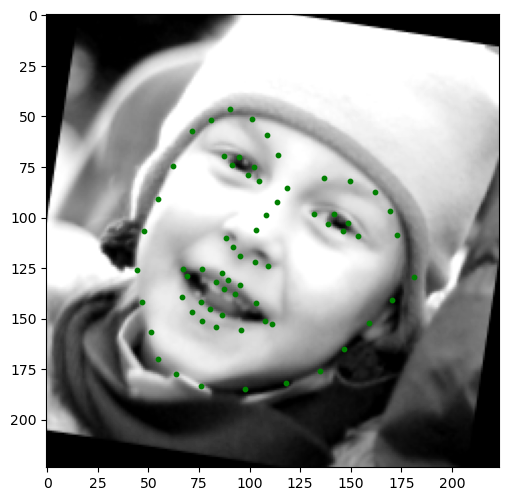

In [9]:
images, landmarks = next(iter(train_loader))
plt.figure(figsize=(600/100, 600/100), dpi=100)
plt.scatter(landmarks[0,:,0], landmarks[0,:,1], c = 'g', s = 10)
plt.imshow(images[0].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34(pretrained=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=2, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()
#network.load_state_dict(torch.load('./Vacancy_9.pth'))
#network.eval()

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 100

start_time = time.time()
train_losses = []
valid_losses = []
for epoch in range(1,num_epochs+1):
    epoch_time = time.time()
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    train_losses.insert(epoch, loss_train)
    valid_losses.insert(epoch, loss_valid)
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'Vacancy_14.pth') # 1 : dataset : 300W & openCVDNN, network : resnet34(3,1,2), preprocess : 50% of openCVDNN
                                                          # 2 : dataset 3219->3816(multi-face images not ommitted)
                                                          # 3 : dataset split (open only)
                                                          # 7 : oversampling & downsampling (0.5 : 19)
                                                          # 8 : oversampling & downsampling (0.25 : 9)
                                                          # 9 : oversampling (1:39)
                                                          # 10 : oversampling (1:39) WITH 200 EPOCHS
                                                          # 11 : oversampling (1:39) with smaller kernel
                                                          # 12 : data : 300w, flips added, pretraiend on (10+ : overfitting)
                                                          # 13 : data : 300w, flips added, pretraiend off
                                                          # 14 : data : flips added

        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        print("Total Elapsed Time : {} s".format(time.time()-epoch_time))
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

import csv
with open('Vacancy_14_epochs.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(train_losses) 
    writer.writerow(valid_losses) 

In [109]:
import csv
with open('Vacancy_12_epochs.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(train_losses) 
    writer.writerow(valid_losses) 